In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Очередь с приоритетом

In [2]:
class PriorityQueue:
    
    def __init__(self):
        self.objects = np.array([])
    
    def __str__(self):
        obj_in_str = ''
        if self.objects.shape[0] != 0:
            for obj in self.objects:
                obj_in_str += 'Index: ' + str(obj[0]) + '\n' + 'Reach dist: ' + str(obj[1]) + '\n' + '\n'
        else:
            obj_in_str = 'nothing'
        return obj_in_str
    
    def insert_or_update__element(self, ind, dist):
        # добавляет в очередь (массив self.objects) новый элемент 
        # (с индексом ind и значением dist (чем меньше, тем больше приоритетность))
        # или заменяет приоритетность, если элемент с ind уже в очереди;
        # сразу же отсортировывает по очередности элементы в массиве self.objects
        
        if self.objects.size == 0:
            self.objects = np.array([[ind, dist]])
            return
        
        inds = self.objects[:, 0]
        if ind in inds:
            self.objects[np.where(inds == ind), 1] = dist
        else:
            self.objects = np.vstack( (self.objects, np.array([ind, dist])) )
        
        sort_order = np.argsort(self.objects[:, 1])
        self.objects = self.objects[sort_order]
        
        
    def next__element(self):
        # возвращает элемент с минимальным значением dist и убирает его из очереди
        
        elem = self.objects[0]
        self.objects = self.objects[1:]
        
        return elem

In [3]:
pq = PriorityQueue()

In [4]:
print(pq)

nothing


In [5]:
pq.objects

array([], dtype=float64)

In [6]:
pq.insert_or_update__element(1,0.5)
pq.objects

array([[1. , 0.5]])

In [7]:
pq.insert_or_update__element(2,0.3)
pq.objects

array([[2. , 0.3],
       [1. , 0.5]])

In [8]:
pq.insert_or_update__element(3,0.7)
pq.objects

array([[2. , 0.3],
       [1. , 0.5],
       [3. , 0.7]])

In [9]:
pq.insert_or_update__element(3,0.3)
pq.objects

array([[2. , 0.3],
       [3. , 0.3],
       [1. , 0.5]])

In [10]:
pq.next__element()

array([2. , 0.3])

In [11]:
pq.objects

array([[3. , 0.3],
       [1. , 0.5]])

In [12]:
print(pq)

Index: 3.0
Reach dist: 0.3

Index: 1.0
Reach dist: 0.5




### Данные

In [13]:
data_part1 = np.random.normal(loc=1.2, scale=0.085, size=(30,2))
data_part2 = np.random.normal(loc=0.5, scale=0.08, size=(30,2))
data = np.vstack((data_part2, data_part1))

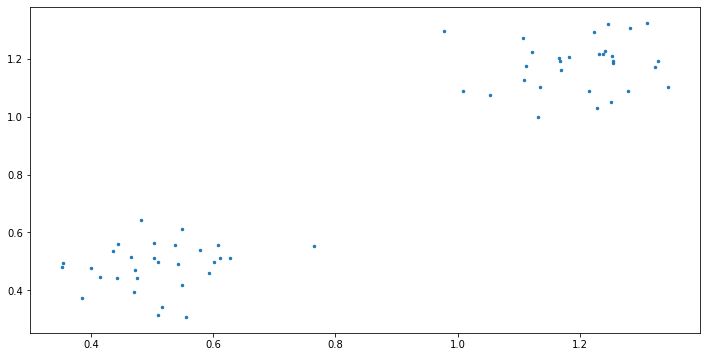

In [16]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(data[:,0], data[:,1], s=6)
plt.show()

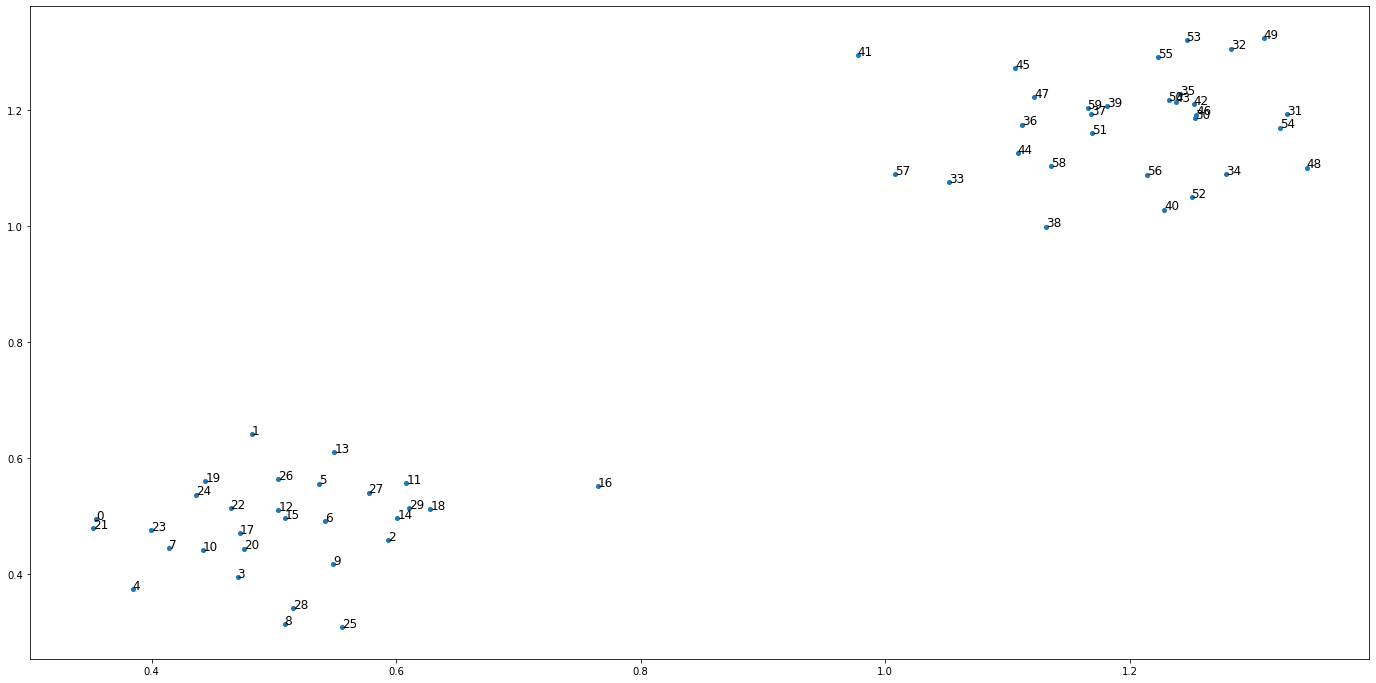

In [17]:
fig, ax = plt.subplots(figsize=(24, 12))
ax.scatter(data[:,0], data[:,1], s=16)

ind = 0
for obj in data:
    ax.annotate(str(ind), xy=(obj[0], obj[1]), size=12)
    ind += 1

plt.show()

### Предварительные вычисления расстояний объектов

In [42]:
m = 1 # для метрики ( (a1-b1)^m + (a2-b2)^m + (a3-b3)^m + ... )^1/m
eps = 2.5 # радиус окрестности данной точки, точки в которой считаются её соседями
# корневая точка - точка, в eps окрестности которой содержится minPts точек (помимо неё)
minPts = 4 # минимальное число соседей, чтобы данная точка считалась корневой

In [43]:
def calc__distance(obj1, obj2, m):
    # вычисление расстояния между точками
    return np.sum(np.abs(obj1 - obj2)**m)**(1/m)

In [44]:
def calc__matrix_of_distances(data, m):
    # вычисление матрицы расстояний (все попарные расстояния между точками)
    r_matrix = np.zeros((data.shape[0], data.shape[0]))
    for i in range(data.shape[0] - 1):
        for j in range(i+1, data.shape[0]):
            r_matrix[i, j] = calc__distance(data[i], data[j], m)
            r_matrix[j, i] = r_matrix[i, j]
    return r_matrix

In [45]:
r_matrix = calc__matrix_of_distances(data, m)
r_matrix

array([[0.        , 0.27481417, 0.27415475, ..., 1.24787118, 1.38965872,
        1.51991128],
       [0.27481417, 0.        , 0.29421292, ..., 0.97305701, 1.11484455,
        1.24509711],
       [0.27415475, 0.29421292, 0.        , ..., 1.04536334, 1.18715088,
        1.31740344],
       ...,
       [1.24787118, 0.97305701, 1.04536334, ..., 0.        , 0.14178754,
        0.2720401 ],
       [1.38965872, 1.11484455, 1.18715088, ..., 0.14178754, 0.        ,
        0.13025256],
       [1.51991128, 1.24509711, 1.31740344, ..., 0.2720401 , 0.13025256,
        0.        ]])

In [46]:
class MyObject:
    
    def __init__(self, ind, coords, r_matrix, eps, minPts):
        
        # уникальный индекс нашего объекта (наш объект - конкретная реализация данного класса)
        self.ind = ind
        # координаты нашего объекта
        self.coords = coords
        
        # расстояния до всех объектов от нашего (включая расстояние, равное 0)
        self.dist__of_all = r_matrix[ind]
        # соседи нашего объекта в нашей окрестности (их индексы; среди этих индексов есть индекс и нашего объекта)
        self.neighbours = np.where(r_matrix[ind] <= eps)[0]
        # расстояния до всех соседей в нашей окрестности
        self.dist__of_neighbours = r_matrix[ind, self.neighbours]
        
        # минимальный радиус окрестности r вокруг корневого объекта, 
        # при котором в случае eps == r он ещё остаётся корневым (так называемый core distance);
        # core distance определено, если наш объект корневой (число соседей (без него) >= minPts)
        if self.neighbours.size - 1 >= minPts:
            self.core_distance = np.sort(self.dist__of_neighbours)[minPts]
        else:
            self.core_distance = np.inf
        
        # обработан ли наш объект
        self.processed = False
        
        # в конце работы должно быть посчитано расстояние достижимости (reachability distance), 
        # которое определяется между двумя объектами a и b (при этом a - корневой) 
        # как max(обычное_расстояние(a, b), core_distance(a));
        
        # в алгоритме расстояние достижимости будет вычисляться от нашего объекта до ближайшего корневого объекта,
        # для которого наш объект является соседом
        # (в терминах алгоритма наш объект directly density reachable от этого ближайшего корневого объекта)
        self.reachability_distance = None # после работы алгоритма будет inf, если объект некорневой
    
    def __str__(self):
        obj_in_str = 'Index: ' + str(self.ind) + '\n' + \
                     'Coords: ' + str(self.coords[0]) + '   ' +str(self.coords[1]) + '\n' + \
                     'Distances from all: ' + str(self.dist__of_all) + '\n' + \
                     'Neighbours indexes: ' + str(self.neighbours) + '\n' + \
                     'Distances from neighbours' + str(self.dist__of_neighbours) + '\n' + \
                     'Core distance: ' + str(self.core_distance) + '\n' + \
                     'Processed: ' + str(self.processed) + '\n' + \
                     'Reachability distance: ' + str(self.reachability_distance) + '\n'
        return obj_in_str
        
    def plot__neighbours(self, data):
        # рисует все точки с их индексами, закрашивая соседей нашего объекта
        fig, ax = plt.subplots(figsize=(24, 12))
            
        ax.scatter(data[:,0], data[:,1], s=16, c='b')
        ax.scatter(data[self.neighbours,0], data[self.neighbours,1], s=36, c='g')
        ax.scatter(data[self.ind,0], data[self.ind,1], s=36, c='y') # наш объект жёлтый
            
        ind = 0
        for obj in data:
            ax.annotate(str(ind), xy=(obj[0], obj[1]), size=12)
            ind += 1

        plt.show()

In [47]:
inds = np.arange(0, data.shape[0])
allObjects = np.array([MyObject(ind, coords, r_matrix, eps, minPts) for ind, coords in zip(inds, data)])

In [48]:
print(allObjects[0])

Index: 0
Coords: 0.3547624156536948   0.49467268086474125
Distances from all: [0.         0.27481417 0.27415475 0.21489832 0.15059328 0.24396437
 0.19003508 0.10928704 0.33400823 0.27096248 0.14050873 0.31636427
 0.16497349 0.31085767 0.24868379 0.15651606 0.46768121 0.14120906
 0.29087167 0.15560826 0.17104024 0.017989   0.12921598 0.06291718
 0.12414113 0.3872568  0.21776123 0.2690046  0.31388797 0.27501011
 1.59029493 1.67206987 1.73913959 1.27866177 1.51916099 1.61907384
 1.43774283 1.51166958 1.2808975  1.53908406 1.40704906 1.42311511
 1.61277134 1.60270964 1.38433513 1.52889119 1.5967928  1.49455859
 1.59612112 1.78477602 1.59919552 1.48000769 1.45083808 1.71734107
 1.64368442 1.66566598 1.45370122 1.24787118 1.38965872 1.51991128]
Neighbours indexes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]
Distances from neighbours[0.         0.27481417

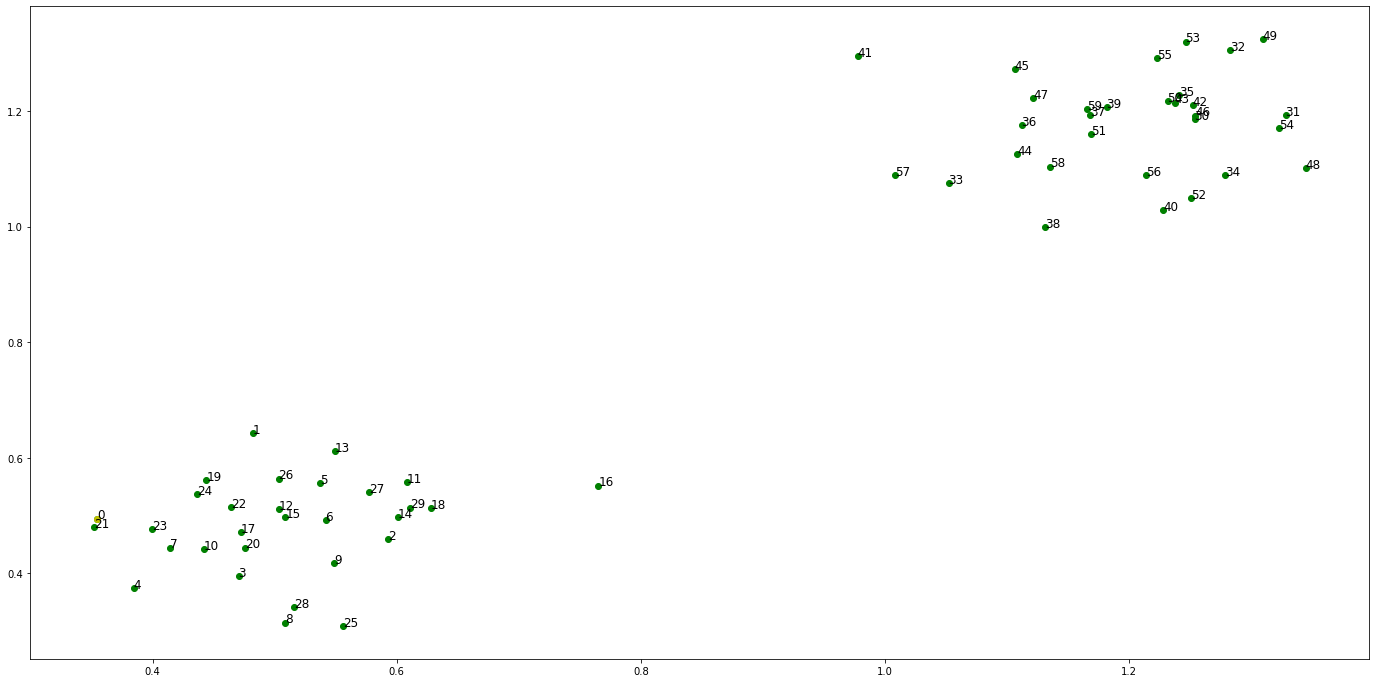

In [49]:
allObjects[0].plot__neighbours(data)

### Работа алгоритма

In [50]:
# массив order - порядок объектов, в котором должен строиться график расстояния достижимости;
# этот порядок формируется таким образом, 
# чтобы по мере прохождения по всем точкам сканировать окрестность каждой точки
# и из неё заносить в order в первую очередь те точки, которые имеют наименьшие расстояния достижимости; 
# так обрабатывается кластер за кластером, учитывается иерархия этих кластеров
order = []

pq = PriorityQueue()

In [170]:
def update_pq(obj, allObjects, pq):
    # для соседей очередного корневого объекта вычисляет расстояния достижимости между ним и соседями
    # (или обновляет это расстояние, если оно уже было посчитано, если новое меньше)
    
    #obj.plot__neighbours(data)
    
    neighbObjects = allObjects[obj.neighbours]
    for neighb_obj in neighbObjects:
        
        if neighb_obj.processed == False:
        
            if neighb_obj.ind != obj.ind:
            
                new_r_dist = max(obj.core_distance, r_matrix[obj.ind, neighb_obj.ind])
            
                if type(neighb_obj.reachability_distance) == type(None):
                    neighb_obj.reachability_distance = new_r_dist
                    pq.insert_or_update__element(neighb_obj.ind, neighb_obj.reachability_distance)
                else:
                    if new_r_dist < neighb_obj.reachability_distance:
                        neighb_obj.reachability_distance = new_r_dist
                        pq.insert_or_update__element(neighb_obj.ind, neighb_obj.reachability_distance)
    #print(pq)
    
    return pq 

In [171]:
def expand_cluster_order(obj, allObjects, pq, order):
    
    obj.processed = True
    order.append(obj.ind)
    
    #print(order)
    
    if obj.core_distance != np.inf:
        pq = update_pq(obj, allObjects, pq)
        
        while pq.objects.shape[0] != 0:
            
            # будет взят объект с наименьшим расстоянием достижимости
            curr_obj = allObjects[int(pq.next__element()[0])]
            
            curr_obj.processed = True
            order.append(curr_obj.ind)
            
            #print(order)
            
            if curr_obj.core_distance != np.inf:
                pq = update_pq(curr_obj, allObjects, pq)

In [172]:
for obj in allObjects:
    if obj.processed == False:
        expand_cluster_order(obj, allObjects, pq, order)

In [165]:
def create_colors(obj_num):
    # создаёт последовательность цветов для всех отрезков, соединяющих точки в порядке массива order
    
    if (obj_num % 3 != 0): # для некратного трём obj_num вычисляется чуть больше цветов (до ближайшего кратного)
        obj_num += 1
        if (obj_num % 3 != 0):
            obj_num += 1
    
    color_change = int(obj_num / 3) + 1
    t1 = np.linspace(0, 0.6, color_change)
    t1 = t1[:, np.newaxis]
    t2 = np.zeros((color_change, 2))
    t3 = np.hstack((t1, t2))
    t4 = np.copy(t3)
    t4[:, 1] = t4[:, 0]
    t4[:, 0] = 1
    t5 = np.ones((color_change, 2))
    t6 = np.hstack((t5, t1))
    t7 = np.vstack((t3[:color_change - 2], t4[:color_change - 2], t6))
    return t7

In [166]:
create_colors(60)

array([[0.  , 0.  , 0.  ],
       [0.03, 0.  , 0.  ],
       [0.06, 0.  , 0.  ],
       [0.09, 0.  , 0.  ],
       [0.12, 0.  , 0.  ],
       [0.15, 0.  , 0.  ],
       [0.18, 0.  , 0.  ],
       [0.21, 0.  , 0.  ],
       [0.24, 0.  , 0.  ],
       [0.27, 0.  , 0.  ],
       [0.3 , 0.  , 0.  ],
       [0.33, 0.  , 0.  ],
       [0.36, 0.  , 0.  ],
       [0.39, 0.  , 0.  ],
       [0.42, 0.  , 0.  ],
       [0.45, 0.  , 0.  ],
       [0.48, 0.  , 0.  ],
       [0.51, 0.  , 0.  ],
       [0.54, 0.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [1.  , 0.03, 0.  ],
       [1.  , 0.06, 0.  ],
       [1.  , 0.09, 0.  ],
       [1.  , 0.12, 0.  ],
       [1.  , 0.15, 0.  ],
       [1.  , 0.18, 0.  ],
       [1.  , 0.21, 0.  ],
       [1.  , 0.24, 0.  ],
       [1.  , 0.27, 0.  ],
       [1.  , 0.3 , 0.  ],
       [1.  , 0.33, 0.  ],
       [1.  , 0.36, 0.  ],
       [1.  , 0.39, 0.  ],
       [1.  , 0.42, 0.  ],
       [1.  , 0.45, 0.  ],
       [1.  , 0.48, 0.  ],
       [1.  , 0.51, 0.  ],
 

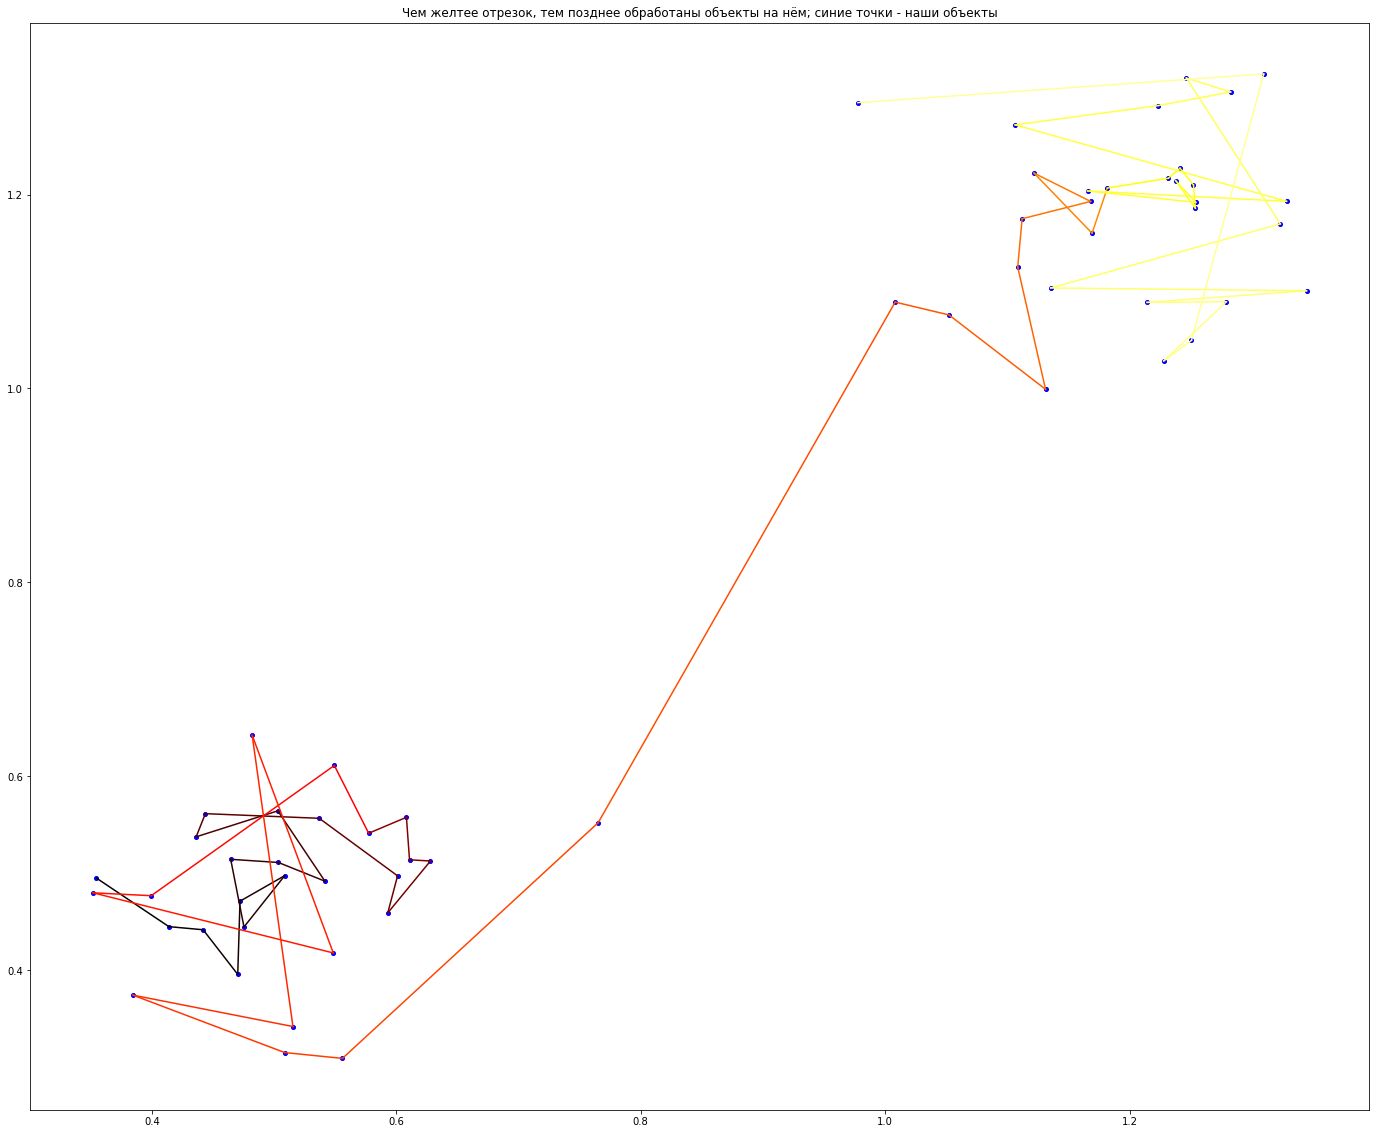

In [175]:
colors_array = create_colors(allObjects.shape[0])
colors_tuple = list(map(tuple, colors_array[:]))

fig, ax = plt.subplots(figsize=(24, 20))
for obj1, obj2, color in zip(allObjects[order][:allObjects.shape[0] - 1], allObjects[order][1:], colors_tuple):
    
    plot_partx = [obj1.coords[0], obj2.coords[0]]
    plot_party = [obj1.coords[1], obj2.coords[1]]
    ax.plot(plot_partx, plot_party, c=color)

ax.scatter(data[:,0], data[:,1], s=16, c='b')

plt.title('Чем желтее отрезок, тем позднее обработаны объекты на нём; синие точки - наши объекты')
plt.show()

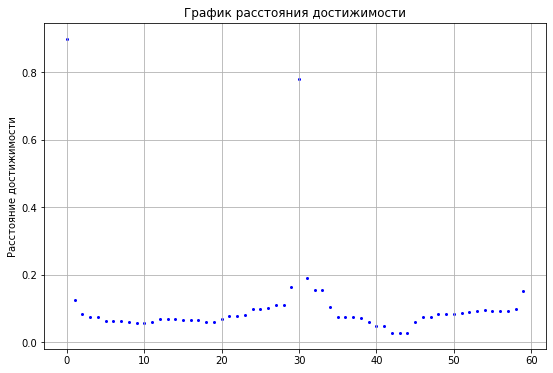

In [179]:
fig, ax = plt.subplots(figsize=(9, 6))

reach = []
for obj in allObjects:
    if type(obj.reachability_distance) == type(None):
        reach.append(0.9)
    else:
        reach.append(obj.reachability_distance)
reach = np.array(reach)

ax.scatter(np.arange(0,reach.shape[0]), reach[order], s=4, c='b')
plt.grid(True)
plt.title('График расстояния достижимости')
plt.ylabel('Расстояние достижимости')
plt.show()

In [162]:
ind_cl = np.concatenate([np.ones((29)), np.array([-1]), np.ones((30))*2])
ind_cl

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1., -1.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.])

In [163]:
ind_cl[order]

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.])